# Neural Network for Image Classification with Numpy

In this notebook, I'll be making a Neural network for image classification on the MNIST Dataset. A dataset containing handwritten digits of 60,000 training examples and 10,000 testing examples.

Goals:
- [Loading Data and Initializing Parameters](#loading-the-data)
- [Forward Propagation](#forward-propagation)
- [Backward Propagation](#backward-propagation)
- [Testing the model](#testing-the-model)

In [263]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import helper as mnist

## Loading The Data

A set of very usual helper functions provided by MNIST is available in helper.py containing the functions needed to load, and view the images in the dataset.

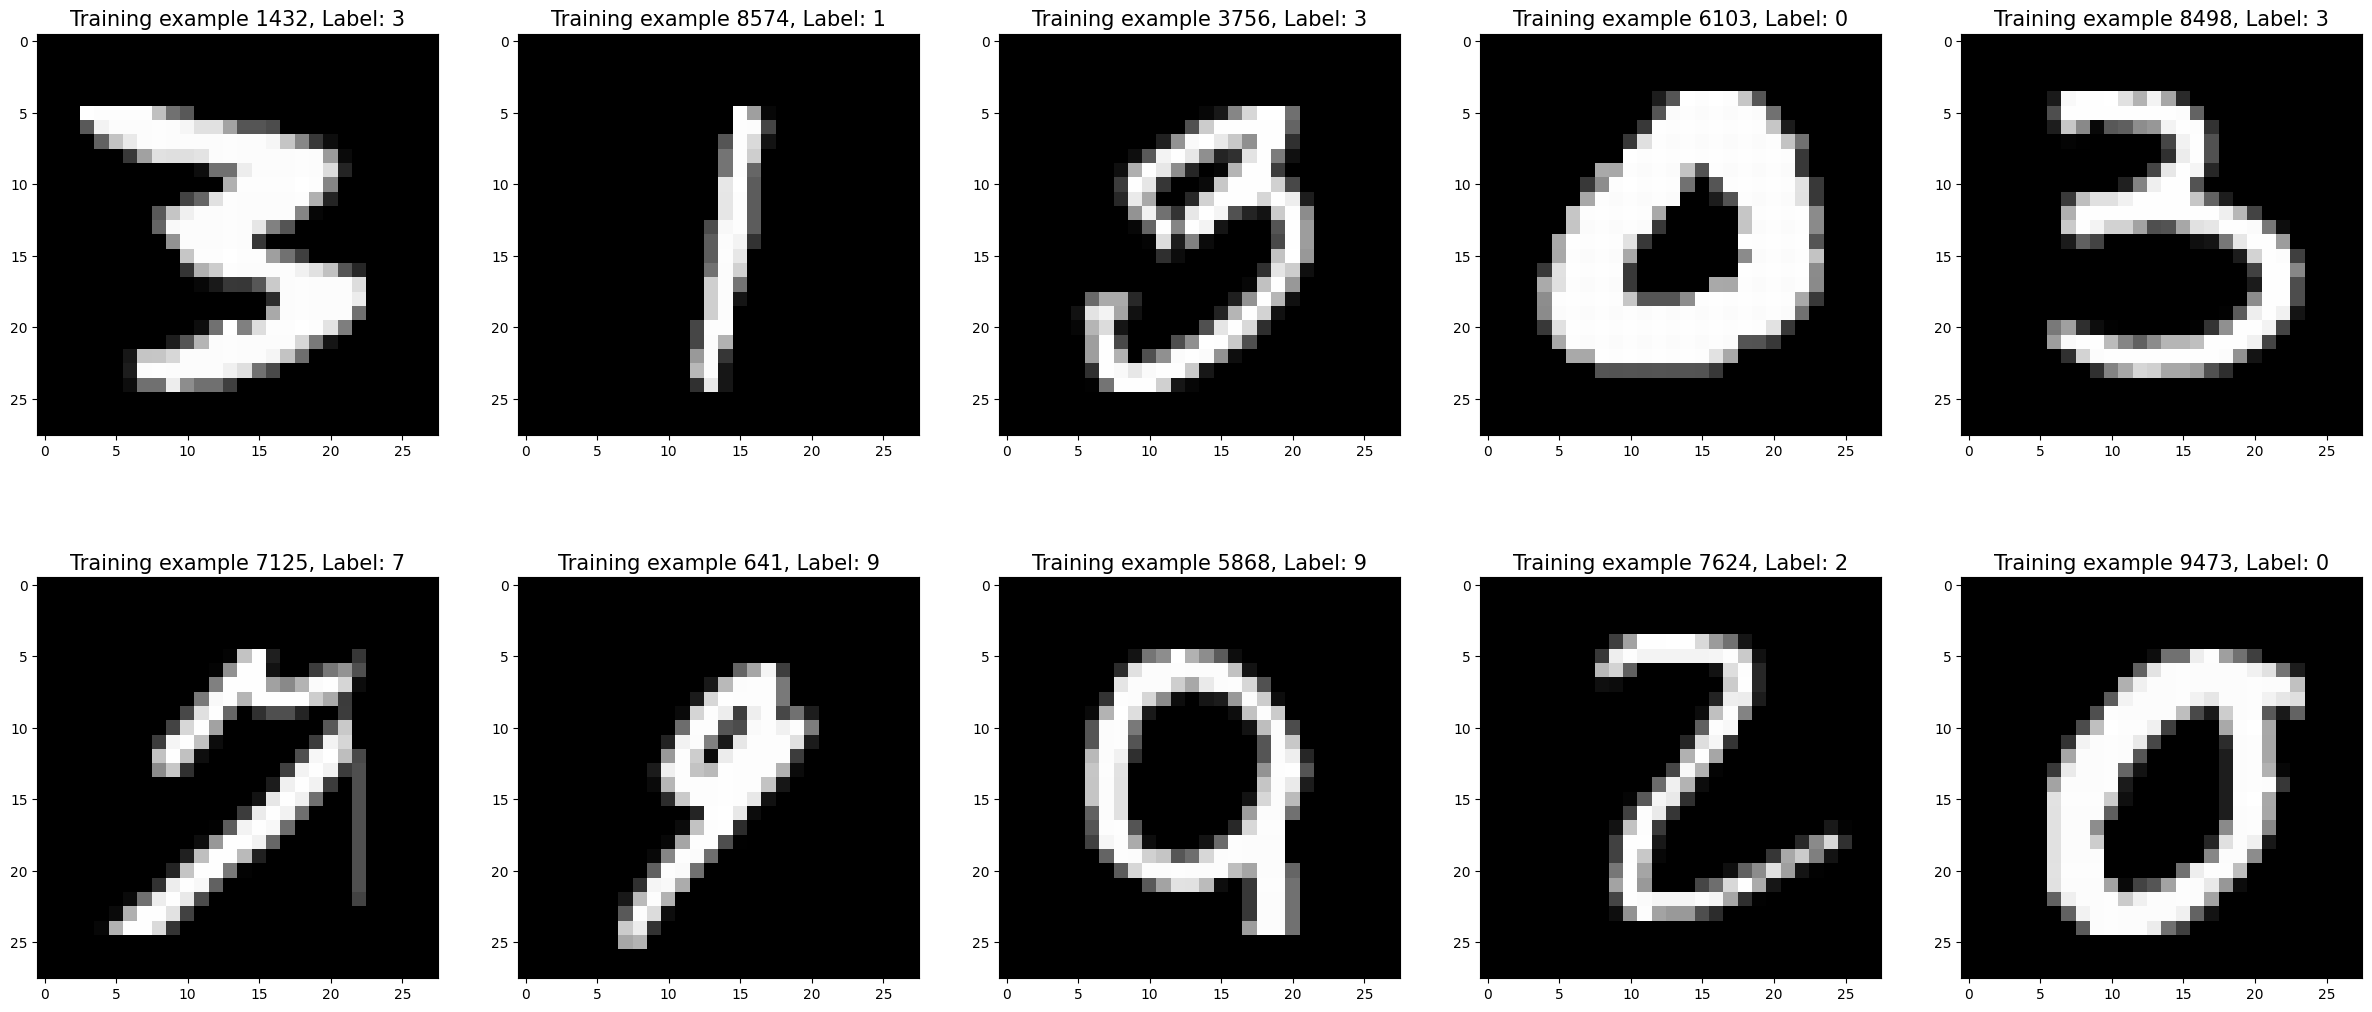

In [264]:
training_images, training_labels = 'train-images.idx3-ubyte', 'train-labels.idx1-ubyte'
testing_images, testing_labels = 't10k-images.idx3-ubyte', 't10k-labels.idx1-ubyte'
data = mnist.MnistDataloader(training_images, training_labels, testing_images, testing_labels) # Load data using helper function
(x_train, y_train), (x_test, y_test) = data.load_data()

## For visualizing the dataset ##
test_list, title_list = [], []
for i in range(1, 11):
    r = np.random.randint(1, 10000)
    test_list.append(x_train[r])
    title_list.append(f'Training example {r}, Label: {str(y_train[r])}')

mnist.show_images(test_list, title_list) # Helper function to view images

# Converting to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = x_train.reshape(x_train.shape[0], -1).T # Reshaping x_train to correct shape of (784, 60000) for correct parameter initialization

## Initializing Parameters

In a deep neural network, the dimensions of parameters for each layer is: (dimension of current layer, dimension of previous layer).
I'll create a function that takes input the dimensions of the neural network, and outputs a list of parameters.

In [265]:
def initialize_parameters_deep(architecture):
    np.random.seed(42)
    parameters = {}
    for l in range(1, len(architecture)):
        parameters["W" + str(l)] = np.random.randn(architecture[l]["units"], architecture[l-1]["units"]) * np.sqrt(2 / architecture[l-1]["units"]) # (current layer dimension, previous layer domimension)
        parameters["b" + str(l)] = np.zeros((architecture[l]["units"], 1))
    return parameters

## Forward Propagation

To train a network, it must go through 2 phases: **Forward** Propagation and **Backward** Propagation.

In Forward Propagation:
- Define activations (In this case I used ReLU as the hidden layer's activations, and softmax for the output)
- Store the outputs, and parameters for every step as Cache (To be used later for calculating the gradients in backprop)
- Define a cost function (Used categorical_cross_entropy because of the softmax output)

### Categorical Cross Entropy

This cost function is commonly used for softmax outputs, as unlike binary cross-entropy, it can handle multiple classes with a wide range of possible output labels $y$.

The formula is:

$$
\
L = -\frac{1}{m} \sum_{i=1}^{m} \sum_{j=1}^{C} y_{ij} \log \left( \hat{y}_{ij} \right)
\
$$

Where:  
- $m$ = number of examples  
- $C$ = number of classes  
- $y_{ij}$ = true label (one-hot encoded)  
- $\hat{y}_{ij}$ = predicted probability (softmax output)

I defined the one-hot encoder in the function [one_hot(y)](#one-hot-encoding)

In [266]:
def categorical_cross_entropy(y_true, y_pred):
    m = y_true.shape[1]
    loss = -np.sum(y_true * np.log(y_pred + 1e-7)) / m
    return loss
    

### Activation Functions

These are the activation functions used in the network. The **linear function** is often used before applying **ReLU** to introduce non-linearity in the initial layers.
#### 2. ReLU (Rectified Linear Unit)
$
\
f(x) = \max(0, x)
\
$

#### 3. Softmax
$
\
\sigma(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}
\
$

Where:  
- $z_i$ = input to the $i$-th neuron  
- $C$ = number of classes (neurons in the layer)  
- $\sigma(z_i)$ = predicted probability for class $i$

In [267]:
def linear(A_prev, W, b):
    return W @ A_prev + b
def relu(z):
    return np.maximum(0, z)
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    softmax =  exp_z / np.sum(exp_z, axis=0, keepdims=True)
    return softmax
def relu_derivative(z):
    return (z > 0).astype(float)

## Forward Prop
This is the main meat of the forward pass, where we'll combine all previous functions to use the current parameters, itterate over the layers and units, and apply the activations.

In [268]:
def forward_propagation(X, parameters, architecture):
    cache = {}
    A = X
    for l in range(1, len(architecture)):
        A_prev = A
        W = parameters["W" + str(l)]
        b = parameters["b" + str(l)]
        activation = architecture[l]['activation']

        Z = linear(A_prev, W, b)
        if activation == "linear":
            A = Z
        elif activation == "relu":
            A = relu(Z)
        elif activation == "softmax":
            A = softmax(Z)
        cache[l] = {
            "A": A,
            "W": W,
            "Z": Z
        }
    cache[0] = {"A": X}
    return A, cache


### Backwards Propagation

Compute gradients using the chain rule:

**Output Layer:**  
$$ \frac{\partial L}{\partial Z} = \hat{A} - Y \quad\quad \frac{\partial L}{\partial W} = \frac{1}{m} \frac{\partial L}{\partial Z} A^{T} \quad\quad \frac{\partial L}{\partial b} = \frac{1}{m} \sum \frac{\partial L}{\partial Z} $$

**Hidden Layers:**  
$$ \frac{\partial L}{\partial A} = W^{T} \frac{\partial L}{\partial Z_{\text{next}}} \quad\quad \frac{\partial L}{\partial Z} = \frac{\partial L}{\partial A} \cdot f'(Z) $$  
$$ \frac{\partial L}{\partial W} = \frac{1}{m} \frac{\partial L}{\partial Z} A_{\text{prev}}^{T} \quad\quad \frac{\partial L}{\partial b} = \frac{1}{m} \sum \frac{\partial L}{\partial Z} $$

Where:  
- $f'(Z)$ is the derivative of the activation function (e.g., ReLU).  
- $A$ is the activation of the previous layer.
- These gradients are used to update parameters via gradient descent.


In [269]:
def calculate_gradients(architecture, cache, y):
    L = len(architecture) - 1
    m = y.shape[1]
    gradients = {}
    # Output layer
    gradients["dZ" + str(L)] = cache[L]["A"] - y
    gradients["dW" + str(L)] = gradients["dZ" + str(L)] @ cache[L - 1]["A"].T / m
    gradients["db" + str(L)] = np.sum(gradients["dZ" + str(L)], axis=1, keepdims=True) / m

    # Each layer
    for l in reversed(range(1, L)):
        gradients["dA" + str(l)] = cache[l + 1]["W"].T @ gradients["dZ" + str(l + 1)]
        gradients["dZ" + str(l)] = gradients["dA" + str(l)] * relu_derivative(cache[l]["Z"])
        gradients["dW" + str(l)] = gradients["dZ" + str(l)] @ cache[l - 1]["A"].T / m
        gradients["db" + str(l)] = np.sum(gradients["dZ" + str(l)], axis=1, keepdims=True) / m
    return gradients

### Gradient Clipping

However, as I was training this model I came across a major issue. **"Exploding Gradients"** which is when the calculated gradients shoot up into huge values during training, which is a very common issue with ReLU Layered Neural Networks.  
To prevent exploding gradients, we apply **global norm clipping**:

1. Compute the total gradient norm:
$$
\text{total\_norm} = \sqrt{\sum_{i} \left\| g_i \right\|^2}
$$

2. If $\text{total\_norm} > \text{max\_norm}$, scale all gradients:
$$
g_i = g_i \times \frac{\text{max\_norm}}{\text{total\_norm} + \epsilon}
$$

Where:  
- $g_i$ is each individual gradient.  
- $\epsilon$ is a small constant to prevent dividing by zero. (1e-7)

This ensures the overall gradient norm does not exceed `max_norm`
I also applied **learning rate decay** as seen in the [fit_model()](#putting-it-all-together)

In [270]:
def clip_gradients(gradients, max_norm):
    # Calculate total norm
    total_norm = 0
    for key, grad in gradients.items():
        total_norm += np.linalg.norm(grad)**2
    total_norm = np.sqrt(total_norm)

    # Clip the gradients
    if total_norm > max_norm:
        scale = max_norm / (total_norm + 1e-7)
        for key in gradients:
            gradients[key] *= scale
    return gradients

### The Climax: Updating the Parameters

With all gradients computed, we update the weights and biases using **gradient descent**:

$$
W = W - \alpha \frac{\partial L}{\partial W}
$$

$$
b = b - \alpha \frac{\partial L}{\partial b}
$$

Where:  
- $\alpha$ is the **learning rate**.  
- $\frac{\partial L}{\partial W}$ and $\frac{\partial L}{\partial b}$ are the gradients computed from backpropagation.

This step moves the parameters in the direction that minimizes the loss.

In [271]:
def back_propagation(gradients, parameters, architecture, learning_rate=0.01):
    L = len(architecture) - 1
    for l in reversed(range(1, L)):
        parameters["W" + str(l)] -= learning_rate * np.clip(gradients["dW" + str(l)], -1, 1)
        parameters["b" + str(l)] -= learning_rate * np.clip(gradients["db" + str(l)], -1, 1)
    return parameters

## Putting it All Together

Here's the final step, we define a function that mixes and combines everything

In [272]:
def fit_model(architecture, x, y, learning_rate, itterations=100):
    loss_arr = []
    parameters = initialize_parameters_deep(architecture)
    for i in range(itterations):
        learning_rate = 0.03 * (0.9) ** (i // 100)
        A, cache = forward_propagation(x, parameters, architecture)
        gradients = calculate_gradients(architecture, cache, y)
        gradients = clip_gradients(gradients, max_norm=1.0)
        parameters = back_propagation(gradients, parameters, architecture, learning_rate) 
        loss_arr.append(categorical_cross_entropy(y, A))
        if i % 10 == 0: print(f"Epoch {i} || Loss: {categorical_cross_entropy(y, A):.5f} || learning rate: {learning_rate} || Max |dW1|: {np.max(np.abs(gradients['dW1'])):.5f}")
    return parameters, loss_arr

In [273]:
def predict(x, parameters, architecture):
    A, cache = forward_propagation(x, parameters, architecture)
    return A[len(architecture)]

### One Hot Encoding

To represent class labels numerically in classification tasks, we use **one hot encoding**:

- For a label $y = 3$ in a 5-class problem:
$$
y = [0, 0, 0, 1, 0]
$$

- Formula for one-hot vector $\mathbf{y}$:
$$
y_i =
\begin{cases}
1 & \text{if class} = i \\
0 & \text{otherwise}
\end{cases}
$$

This format is essential for computing **categorical cross-entropy loss** with softmax outputs.


In [274]:
def one_hot(y):
    y_hot = np.zeros((y.size, y.max() + 1))
    y_hot[np.arange(y.size), y] = 1
    return y_hot.T

In [275]:
architecture = [
    {"units": x_train.shape[0]},
    {"units": 64, "activation": "relu"},
    {"units": 32, "activation": "relu"},
    {"units": 10,  "activation": "softmax"}
]
y_train = one_hot(y_train)
parameters, loss_arr = fit_model(architecture, x_train, y_train, learning_rate=0.03, itterations=6000)

Epoch 0 || Loss: 13.81874 || learning rate: 0.03 || Max |dW1|: 0.01835
Epoch 10 || Loss: 12.94431 || learning rate: 0.03 || Max |dW1|: 0.01407
Epoch 20 || Loss: 12.03880 || learning rate: 0.03 || Max |dW1|: 0.00807
Epoch 30 || Loss: 11.30975 || learning rate: 0.03 || Max |dW1|: 0.00606
Epoch 40 || Loss: 10.65990 || learning rate: 0.03 || Max |dW1|: 0.00499
Epoch 50 || Loss: 10.04757 || learning rate: 0.03 || Max |dW1|: 0.00459
Epoch 60 || Loss: 9.49427 || learning rate: 0.03 || Max |dW1|: 0.00426
Epoch 70 || Loss: 9.00635 || learning rate: 0.03 || Max |dW1|: 0.00376
Epoch 80 || Loss: 8.57514 || learning rate: 0.03 || Max |dW1|: 0.00345
Epoch 90 || Loss: 8.19062 || learning rate: 0.03 || Max |dW1|: 0.00312
Epoch 100 || Loss: 7.84668 || learning rate: 0.027 || Max |dW1|: 0.00298
Epoch 110 || Loss: 7.57029 || learning rate: 0.027 || Max |dW1|: 0.00285
Epoch 120 || Loss: 7.31911 || learning rate: 0.027 || Max |dW1|: 0.00272
Epoch 130 || Loss: 7.09227 || learning rate: 0.027 || Max |dW1|: 0

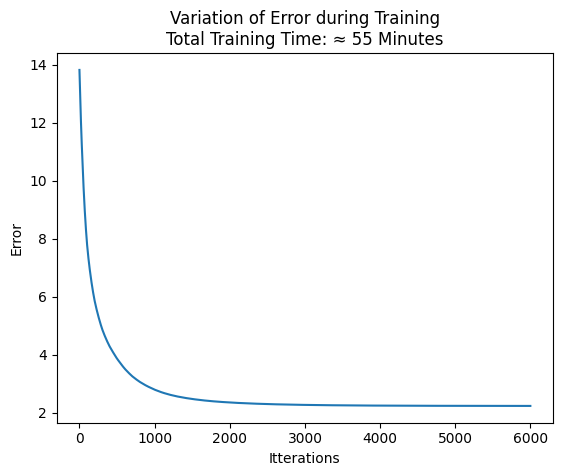

In [278]:
plt.plot(range(6000), loss_arr)
plt.xlabel("Itterations")
plt.ylabel("Error")
plt.title("Variation of Error during Training\nTotal Training Time: \u2248 55 Minutes")
plt.show()

### Conclusion

This is a 3 layer neural network that uses ReLU Activations for the hidden layers and a softmax output to predict and classify handwritten digits. However, with transfer learning, or simply using the same architecture, the possibilities are endless!!

This was Neural Nets!!

==> [Github](https://github.com/lucirie)  
==> [Linkedin](https://www.linkedin.com/in/ziad-alezzi-8727bb345/)